In [9]:
import networkx as nx
import numpy as np
import cvxpy as cp
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import concurrent.futures

Problem setup: 

Paramters: 
- $X \in \mathbb{R}^{n \times n}$ where $X_{i,j}$ represents the amt transit from i to j. 
    - $X_{m,n} = 0$ if we couldn't transit from i to j  
- $T \in \mathbb{R}^{n \times n}$ where $X_{i,j}$ represents the price of i in terms of j. 

Objective: 
- $\max T X^T$

Constraints: 
- $\sum_j X_{ij} - \sum_j X_{ji} = 0 \quad \forall i$  i.e. inflow = outflow 
- $X_{ij} > 0 \quad \forall i,j$

In [2]:
def init(df): 
    # init currency info 
    syms = df.symbol.unique()
    currency_set = set()
    for s in syms: 
        currency_set.add(s.split("/")[0])
        currency_set.add(s.split("/")[1])
    currency_set = list(currency_set)
    currency2index = {}
    for i, s in enumerate(currency_set): 
        currency2index[s] = i
    return currency_set, currency2index

def update_price_mtx(df, currency_set, currency2index, midPrice = False): 
    transit_price_mtx = np.ones((len(currency_set), len(currency_set)))
    for i in range(len(df)): 
        ticker = df["symbol"].iloc[i]
        base = ticker.split("/")[0]
        quote = ticker.split("/")[1]
        if base in currency_set and quote in currency_set: 
            base_idx = currency2index[base]
            quote_idx = currency2index[quote]
            if midPrice: 
                mid_price = (df["bid"].iloc[i] + df["ask"].iloc[i]) / 2
                transit_price_mtx[base_idx, quote_idx] = mid_price
                transit_price_mtx[quote_idx, base_idx] = 1 / mid_price
            else: 
                transit_price_mtx[base_idx, quote_idx] = df["bid"].iloc[i]
                transit_price_mtx[quote_idx, base_idx] = 1 / df["ask"].iloc[i]
    return transit_price_mtx
    
def get_var_loc(df, currency_set, currency2index): 
    var_loc = np.zeros((len(currency_set), len(currency_set)))
    for s in df.symbol.unique(): 
        base = s.split("/")[0]
        quote = s.split("/")[1]
        base_idx = currency2index[base]
        quote_idx = currency2index[quote]
        var_loc[base_idx, quote_idx] = 1
        var_loc[quote_idx, base_idx] = 1 
    return var_loc

def update_obj(price_mtx, var_loc, currency_set, **kwargs): 
    if "sparsity" in kwargs: 
        sparsity = kwargs["sparsity"]
    transit_mtx = np.log(price_mtx)
    # transit_mtx = transit_mtx[var_loc]
    X = cp.Variable((len(currency_set), len(currency_set)))
    obj = cp.Maximize(cp.sum(cp.multiply(transit_mtx, X.T)))
    constraints = [
        X >= 0, 
        X @ np.ones(len(currency_set)) ==  X.T @ np.ones(len(currency_set)), 
        cp.norm(X, "fro") <= 1
    ]
    constraints += [X[i, j] == 0 for i in range(len(currency_set)) for j in range(len(currency_set)) if var_loc[i, j] == 0]
    if "sparsity" in kwargs: 
        z = cp.Variable((len(currency_set), len(currency_set)), boolean=True)
        constraints += [
            X <= z * 1000, 
            X >= -z * 1000, 
            cp.sum(z) <= sparsity
        ]
    prob = cp.Problem(obj, constraints) 
    prob.solve(solver=cp.MOSEK, verbose=False)
    return X.value, prob.value


In [3]:
data = pd.read_csv("data.csv")

In [4]:
data.sort_values(by=["timestamp"], inplace=True)

In [5]:
def find_arbitrage(df, midPrice = False, samples = 5, **kwargs): 
    times = df.timestamp.unique()[:samples]
    Xs = []
    vals = []
    for t in (times): 
        df_t = df[df.timestamp == t]
        currency_set, currency2index = init(df_t)
        price_mtx = update_price_mtx(df_t, currency_set, currency2index, midPrice)
        var_loc = get_var_loc(df_t, currency_set, currency2index)
        X, val = update_obj(price_mtx, var_loc, currency_set, **kwargs)
        Xs.append(X)
        vals.append(val)
    return Xs, vals

In [10]:
data

,timestamp,bid,ask,low,close,volume,symbol
0,2022-01-01 00:00:00,2.389,2.389,2.389,2.389,0.000,1INCH/USD
659000,2022-01-01 00:00:00,8.717,8.717,8.717,8.717,0.000,QTUM/USD4
662000,2022-01-01 00:00:00,8.752,8.752,8.752,8.752,2.292,QTUM/USDT
678000,2022-01-01 00:00:00,18.210,18.250,18.210,18.250,54.888,REP/BUSD
681000,2022-01-01 00:00:00,18.170,18.500,18.170,18.410,1048.268,REP/USD4
...,...,...,...,...,...,...,...
677995,2024-08-23 04:40:00,5.181,5.181,5.181,5.181,0.000,RENDER/USDT
677996,2024-08-23 04:41:00,5.181,5.181,5.181,5.181,0.000,RENDER/USDT
677997,2024-08-23 04:42:00,5.181,5.181,5.181,5.181,0.000,RENDER/USDT
677998,2024-08-23 04:43:00,5.181,5.181,5.181,5.181,0.000,RENDER/USDT


## Price vs spread 

In [6]:
Xs_mid, vals_mid = find_arbitrage(data, midPrice = True, samples = 10)

In [7]:
Xs_spread, vals_spread = find_arbitrage(data, midPrice = False, samples = 10)

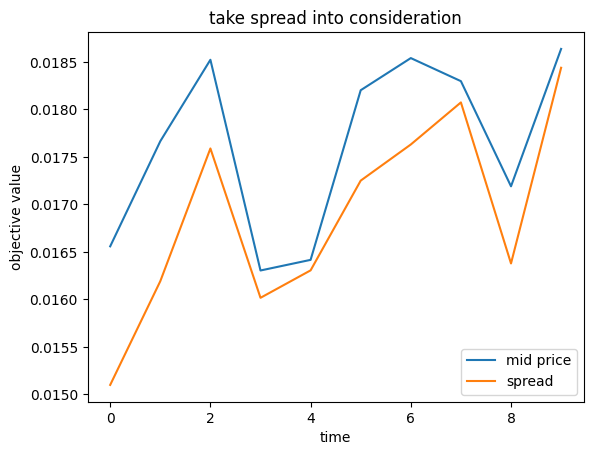

In [8]:
plt.plot(vals_mid, label = "mid price")
plt.plot(vals_spread, label = "spread")
plt.legend()
plt.xlabel("time")
plt.ylabel("objective value")
plt.title("take spread into consideration")
plt.show()

## Sparsity 

### Triangular: 

In [12]:
args = {"sparsity": 3}
Xs_spread, vals_spread = find_arbitrage(data, midPrice = False, samples = 10, **args)

100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


In [6]:
def run_find_arbitrage(sparsity, data):
    args = {"sparsity": sparsity}
    Xs_spread, vals_spread = find_arbitrage(data, midPrice=False, samples=10, **args)
    return sparsity, vals_spread, Xs_spread

results = []
Xs_spreads = []
sparsities = 11
completed_tasks = 0
total_tasks = sparsities - 3 
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(run_find_arbitrage, n, data): n for n in range(3, sparsities)}
    for future in concurrent.futures.as_completed(futures):
        sparsity, vals_spread, Xs_spread = future.result()
        results.append((sparsity, vals_spread))
        Xs_spreads.append(Xs_spread)
        completed_tasks += 1
        print(f"Completed {completed_tasks}/{total_tasks} tasks")

results.sort(key=lambda x: x[0])

for sparsity, vals_spread in results:
    plt.plot(vals_spread, label=f"sparsity {sparsity}")

plt.legend()
plt.xlabel("time")
plt.ylabel("objective value")
plt.show()

Completed 1/8 tasks
Completed 2/8 tasks
Completed 3/8 tasks
Completed 4/8 tasks
Completed 5/8 tasks


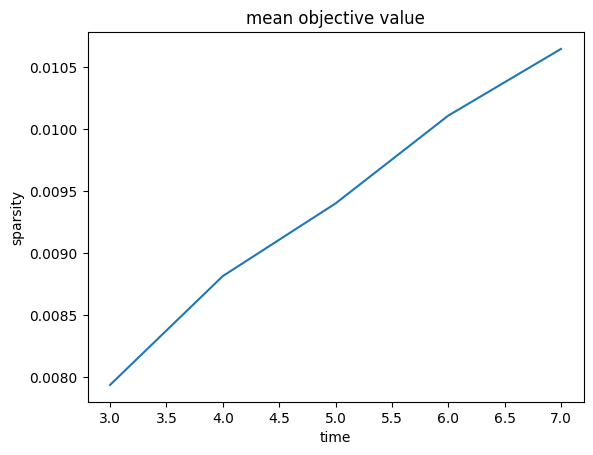

In [21]:
plt.plot(range(3,11),np.array([results[k][1] for k in range(5)]).mean(axis=1))
plt.xlabel("time")
plt.ylabel("sparsity")
plt.title("mean objective value");

In [ ]:
plt.plot()